# Twitter Fake News Detection using LSTM Model

**Author:** Haitao(Pippa) Lin

**Date:** July 2023  

**Institution:** University of California, Santa Barbara  

# Import packages

In [103]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from string import punctuation

In [104]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [105]:
# View files in the current path
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./.DS_Store
./fake news detection.ipynb
./fake news detection.html
./.ipynb_checkpoints/fake news detection-checkpoint.ipynb
./.ipynb_checkpoints/NLP实战-真假新闻识别-checkpoint.ipynb
./data/glove.twitter.27B.100d.txt
./data/Fake.csv
./data/glove.twitter.27B.50d.txt
./data/Fake.csv.zip
./data/glove.twitter.27B.25d.txt
./data/glove.twitter.27B.200d.txt
./data/True.csv.zip
./data/True.csv


In [106]:
true = pd.read_csv("./data/True.csv")
fake = pd.read_csv("./data/Fake.csv")

In [107]:
true.shape, fake.shape

((21417, 4), (23481, 4))

In [108]:
true.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [109]:
true.dtypes

title      object
text       object
subject    object
date       object
dtype: object

In [110]:
true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [111]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [112]:
true["category"] = 1 
fake["category"] = 0
df = pd.concat([true, fake])
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [113]:
'''
sns.set_style("darkgrid")

sns.countplot(df.category)

plt.show()
'''

'\nsns.set_style("darkgrid")\n\nsns.countplot(df.category)\n\nplt.show()\n'

# EDA

In [114]:
df.title.count()

44898

In [115]:
df["subject"].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

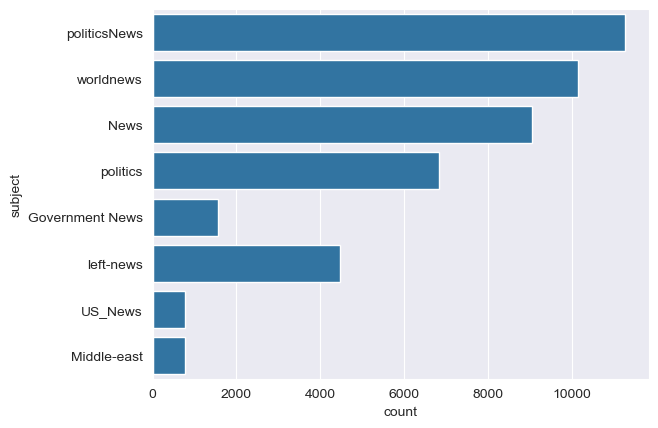

In [116]:
sns.countplot(data=df, y="subject")

plt.show()

In [117]:
print(df.groupby('subject')['category'].value_counts())

subject          category
Government News  0            1570
Middle-east      0             778
News             0            9050
US_News          0             783
left-news        0            4459
politics         0            6841
politicsNews     1           11272
worldnews        1           10145
Name: count, dtype: int64


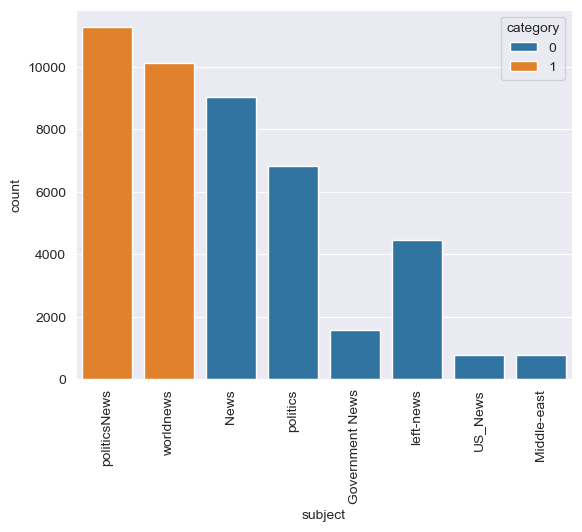

In [118]:
fig = sns.countplot(data=df,
             x="subject",
             hue="category")

fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

plt.show()

# Data Preprocessing

In [119]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pippalin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
# Set stop words
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [121]:
# Parsing HTML & clean
# Set stop words
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    text = re.sub('\[[^]]*\]','',text)
    text = re.sub(r'http\S+', '', text)
    return text

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

df['text']=df['text'].apply(denoise_text)

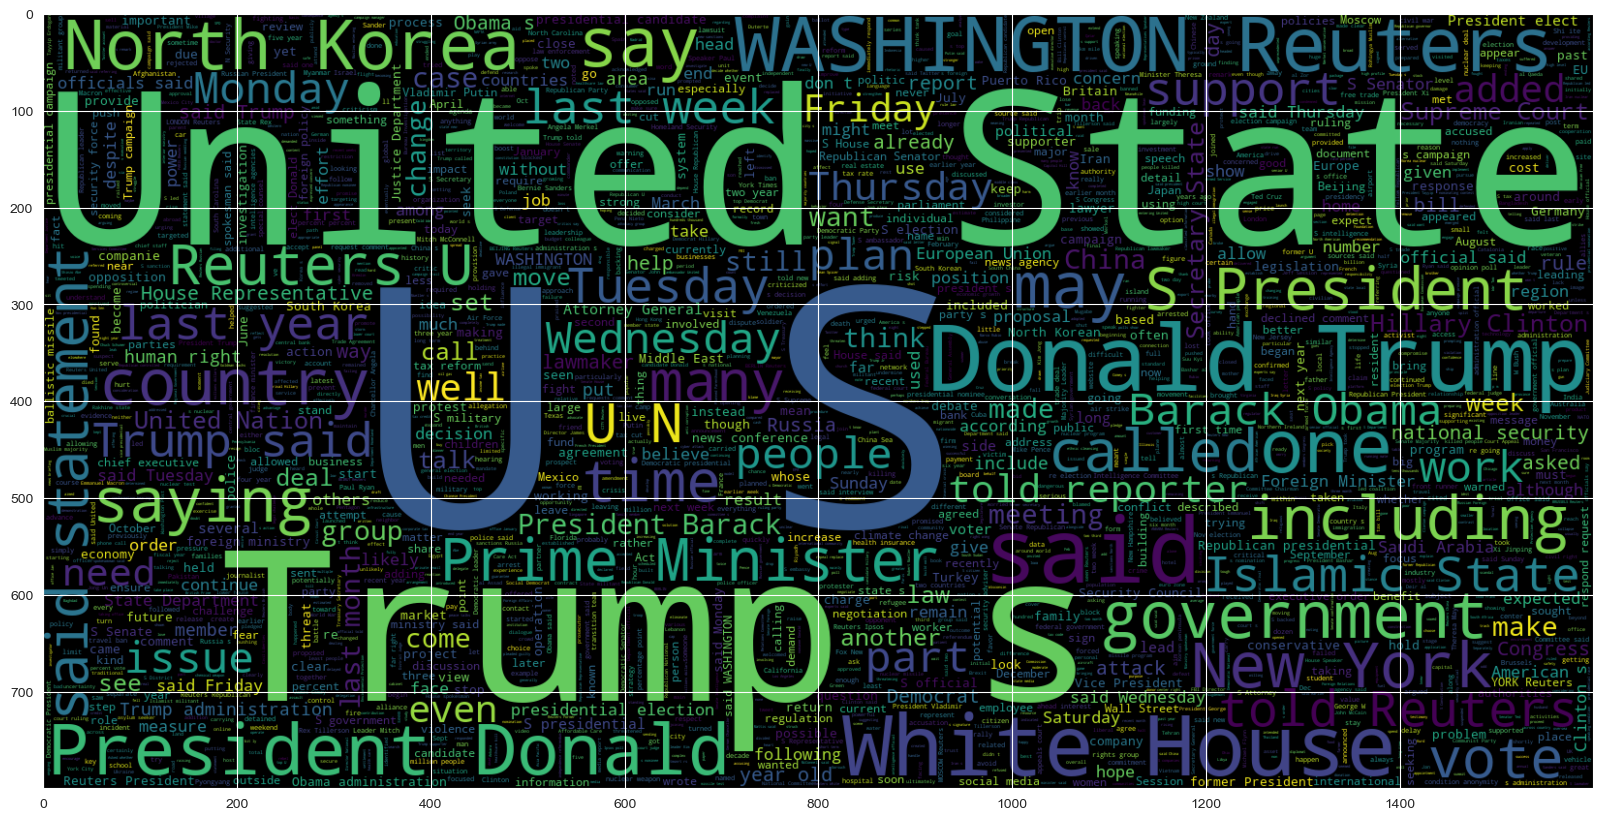

In [122]:
# Real Post
plt.figure(figsize = (20,20)) 

wc = WordCloud(max_words = 2000 , 
               width = 1600 , 
               height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))

plt.imshow(wc , interpolation = 'bilinear')

plt.show()

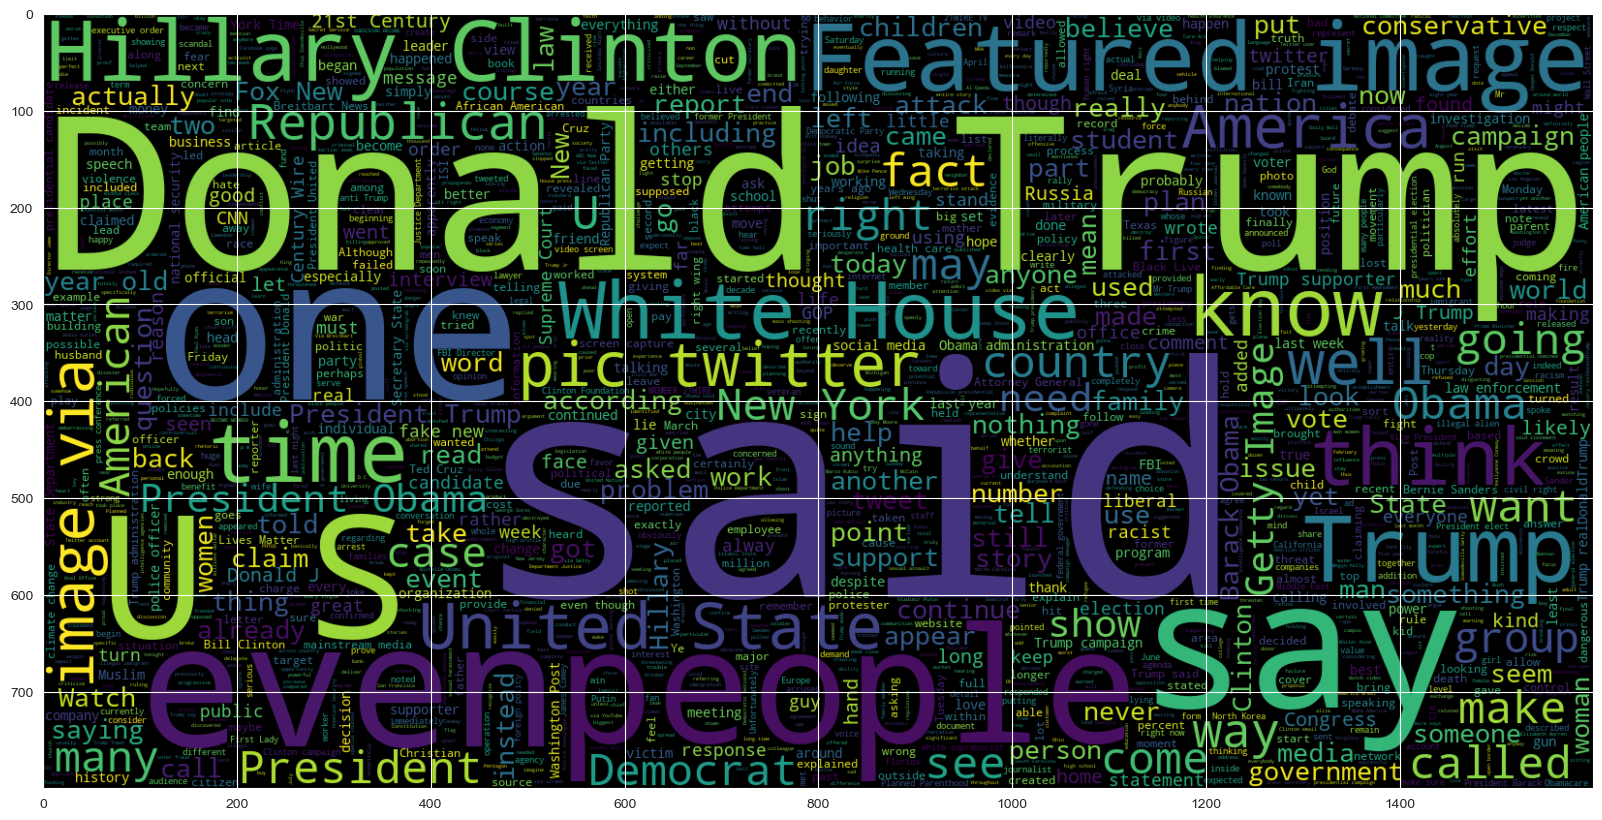

In [123]:
# Fake Post
plt.figure(figsize = (20,20)) 

wc = WordCloud(max_words = 2000 , 
               width = 1600 , 
               height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))

plt.imshow(wc , interpolation = 'bilinear')

plt.show()

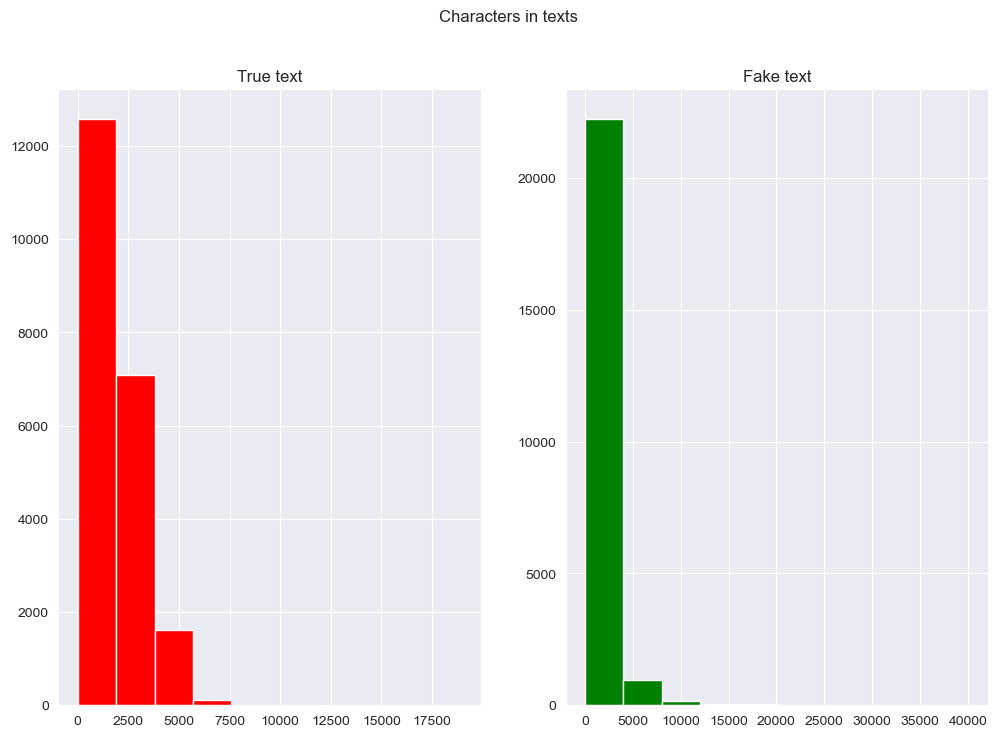

In [124]:
# Post length distribution
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))

text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len, color='red')
ax1.set_title('True text')

text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len, color='green')
ax2.set_title('Fake text')

fig.suptitle('Characters in texts')
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

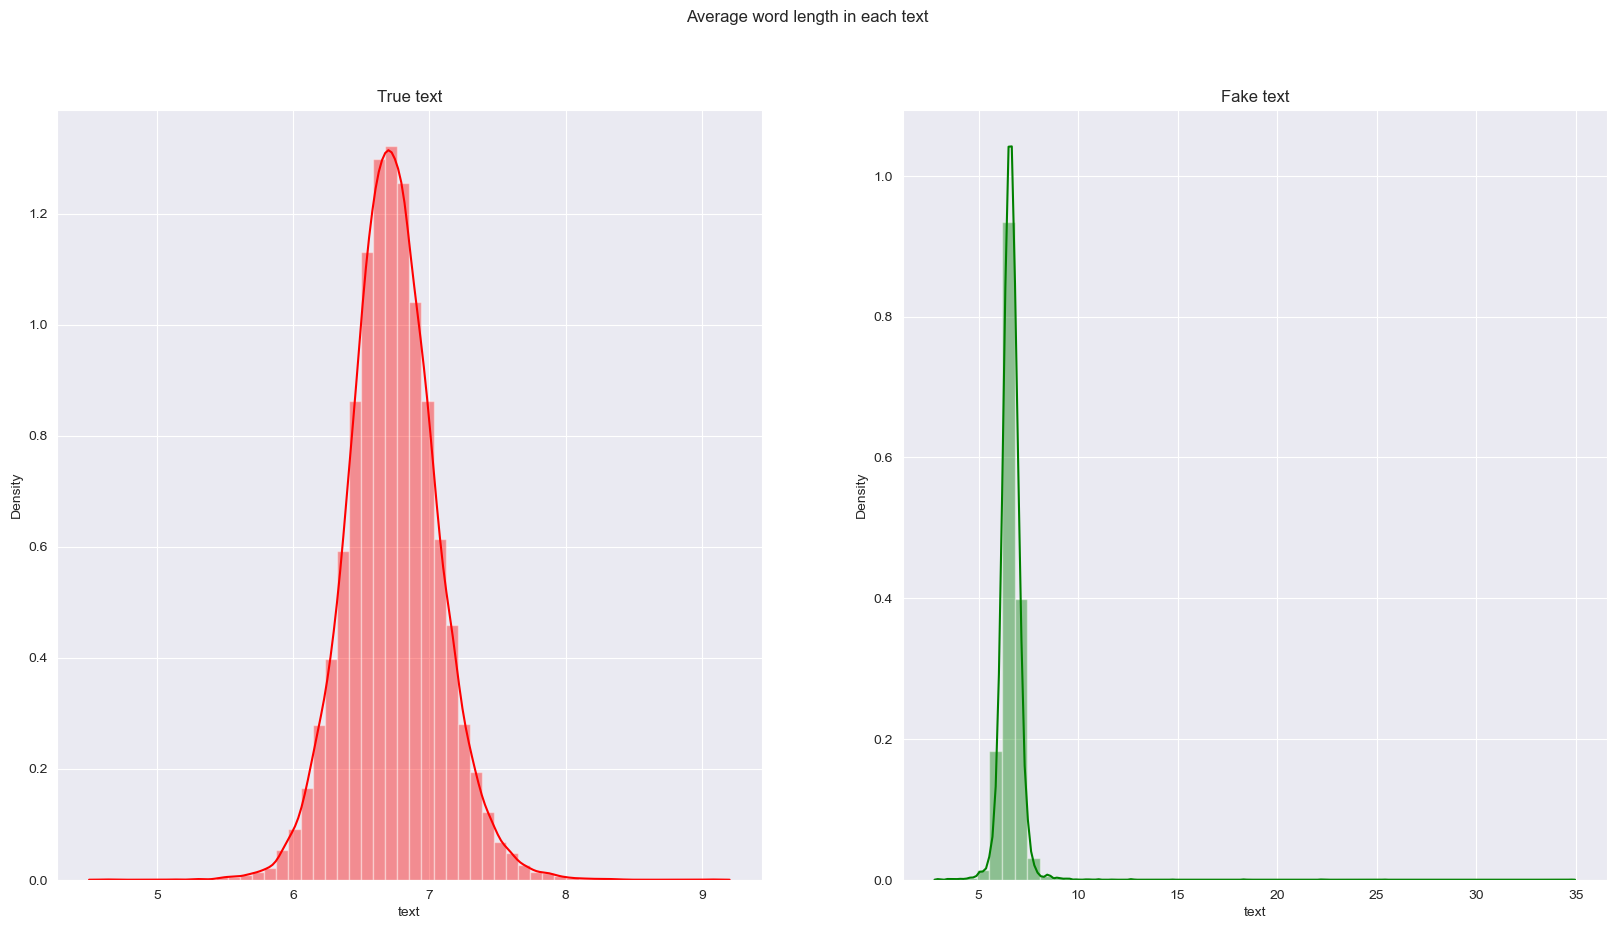

In [125]:
# Average length distribution
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

# Real
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(word.map(lambda x: np.mean(x)),
             ax=ax1, 
             color='red')
ax1.set_title('True text')

# Fake
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),
             ax=ax2,
             color='green')
ax2.set_title('Fake text')

fig.suptitle('Average word length in each text')

# Generate Corpus + N-grams Analysis

In [126]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) head conservative Republi...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) Transgender people allowe...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) special counsel investiga...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) Trump campaign adviser Ge...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) President Donald ...,politicsNews,"December 29, 2017",1


In [127]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():  # split the text into words; generates list
            words.append(j.strip())  # strip spaces and add to list
            
    return words

corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [128]:
from collections import Counter

# most common corpus
counter = Counter(corpus)
most_common = counter.most_common(10)  
most_common = dict(most_common)
most_common

{'Trump': 101288,
 'said': 93137,
 'would': 54351,
 'U.S.': 46115,
 'people': 32968,
 'President': 32294,
 'also': 30314,
 'one': 29297,
 'Donald': 27015,
 'said.': 26195}

In [129]:
# Generate frequency by N-grams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g,g)).fit(corpus)
    
    bag_of_words= vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

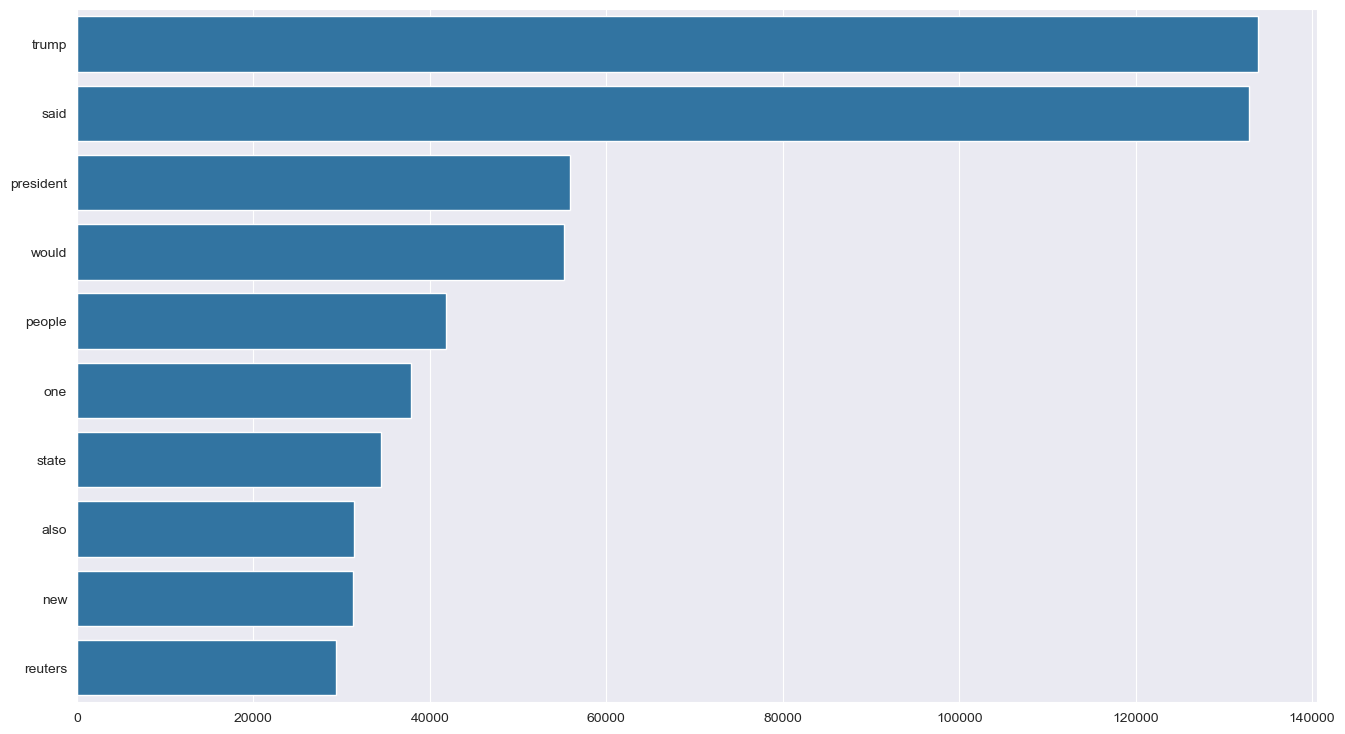

In [130]:
# N-gram Analysis

# Unigram Analysis
plt.figure(figsize = (16,9))

most_common_uni = get_top_text_ngrams(df.text,10,1)

most_common_uni = dict(most_common_uni)

sns.barplot(x=list(most_common_uni.values()),
            y=list(most_common_uni.keys()))

plt.show()


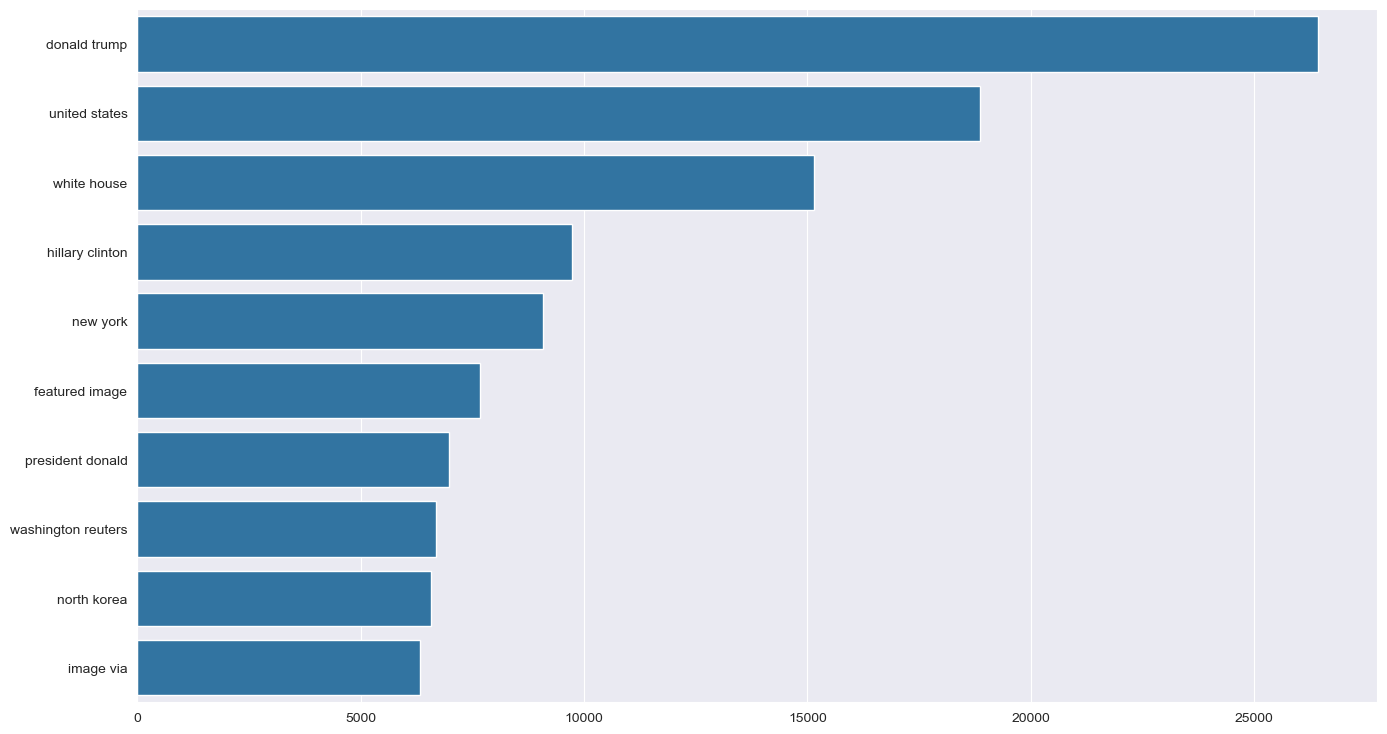

In [131]:
# Bigram Analysis

plt.figure(figsize = (16,9))

most_common_bi = get_top_text_ngrams(df.text,10,2)

most_common_bi = dict(most_common_bi)

sns.barplot(x=list(most_common_bi.values()),
            y=list(most_common_bi.keys()))

plt.show()

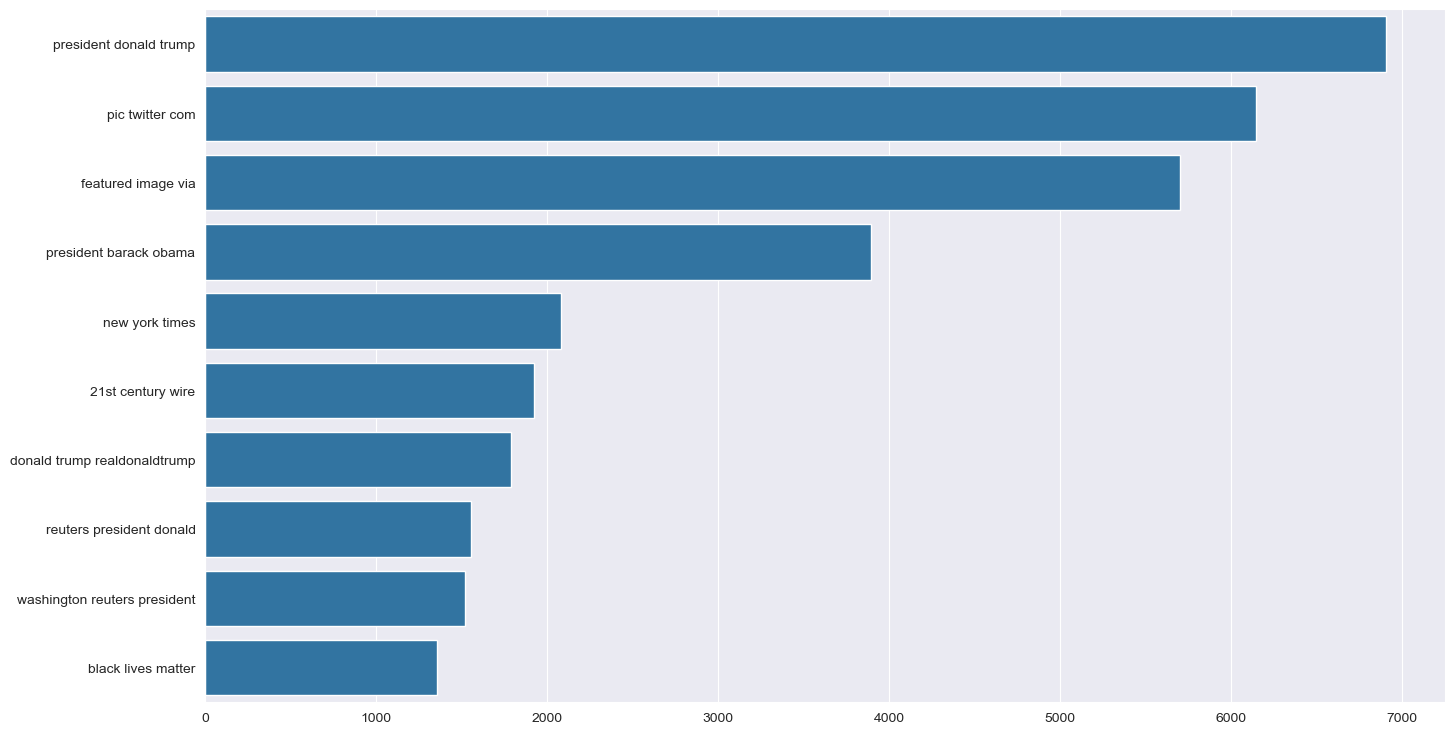

In [132]:
# Trigram Analysis

plt.figure(figsize = (16,9))

most_common_tri = get_top_text_ngrams(df.text,10,3)

most_common_tri = dict(most_common_tri)

sns.barplot(x=list(most_common_tri.values()),
            y=list(most_common_tri.keys()))

plt.show()


# Modeling

In [133]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)
max_features = 10000
maxlen = 300

### Tokenizer and Vocabulary Ranking

1. **Vocabulary Creation**: The Tokenizer creates a vocabulary from all unique words found in the corpus it is fit on, ranking them by frequency. The most frequent word gets the smallest index, starting from 1 (not 0, as index 0 is reserved for padding).

2. **Top n Words**: When you specify num_words in the Tokenizer, you limit the vocabulary to the top n words by frequency. For example, if num_words=10, only the top 10 most frequent words will be considered in the tokenization process. Words outside the top 10 won't be tokenized and thus won't appear in the sequences.

3. **Sequence Generation**: Each sentence in the corpus is converted into a sequence of integers. Here, each integer represents the index of a word in the vocabulary. If a word in the sentence isn’t in the top n frequent words list, it's ignored (i.e., it doesn't get an index and isn't included in the output sequence).

4. **Index as a Rank**: In the tokenized sequences, each number directly corresponds to the 'rank' of a word based on its frequency in the training data. For instance, a word represented by the number 1 is the most frequent word in the corpus.

In [134]:
# Tokenize
from keras.utils import pad_sequences
tokenizer = text.Tokenizer(num_words=max_features) # only keep most freq word

# Training
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen) # make sure same length

# Testing
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

Resources
* Glove：https://nlp.stanford.edu/projects/glove/
* https://zhuanlan.zhihu.com/p/50946044

In [135]:
# Pre-trained embedding
EMBEDDING_FILE = './data/glove.twitter.27B.100d.txt'

In [136]:
# Create a dict for word embeddings
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,  encoding='UTF-8'))

In [137]:
# Create a matrix with each row is one vector
all_embs = [emb for emb in embeddings_index.values() if isinstance(emb, np.ndarray)]
all_embs = np.stack(all_embs)
#all_embs = np.stack(embeddings_index.values())

emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1] # Dim of the vector

word_index = tokenizer.word_index # Word with idx in the tokenizer
nb_words = min(max_features, len(word_index)) # Select the top nb_words 

# Initialize using Normal (easier to trian)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= max_features: # only keep word in top #max_feature
        continue
    embedding_vector = embeddings_index.get(word) #retrieve vector for the word
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

# Model Training

In [138]:
batch_size = 256
epochs = 5
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience = 2,
    verbose=1,
    factor=0.5, 
    min_lr=0.00001
)

In [139]:
# Set up the model
model = Sequential()

# Embedding
model.add(Embedding(max_features, 
                    output_dim=embed_size, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False)) # pre-trained embeddings are not updated during backpropagation

model.add(LSTM(units=128 , 
               return_sequences = True , 
               recurrent_dropout = 0.25 , 
               dropout = 0.25))

model.add(LSTM(units=64, 
               recurrent_dropout = 0.1 , 
               dropout = 0.1))

model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [141]:
# Model Training
history = model.fit(x_train, 
                    y_train,
                    batch_size = batch_size , 
                    validation_data = (X_test,y_test) , 
                    epochs = epochs , 
                    callbacks = [learning_rate_reduction])

Epoch 1/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 119s 886ms/step - accuracy: 0.8156 - loss: 0.3919 - val_accuracy: 0.9532 - val_loss: 0.1364 - learning_rate: 0.0010
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 118s 892ms/step - accuracy: 0.9331 - loss: 0.1792 - val_accuracy: 0.9563 - val_loss: 0.1279 - learning_rate: 0.0010
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 117s 890ms/step - accuracy: 0.9496 - loss: 0.1388 - val_accuracy: 0.9646 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 118s 894ms/step - accuracy: 0.9584 - loss: 0.1142 - val_accuracy: 0.9799 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 117s 890ms/step - accuracy: 0.9670 - loss: 0.0924 - val_accuracy: 0.9790 - val_loss: 0.0575 - learning_rate: 0.0010


In [142]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 300, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,337,540 (5.10 MB)

 Trainable params: 168,769 (659.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 168,771 (659.27 KB)

# Evaluation

In [143]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 85s 81ms/step - accuracy: 0.9829 - loss: 0.0515
Accuracy of the model on Training Data is -  98.21518659591675 %


In [144]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9768 - loss: 0.0605
Accuracy of the model on Testing Data is -  97.89754748344421 %


# Visualizations

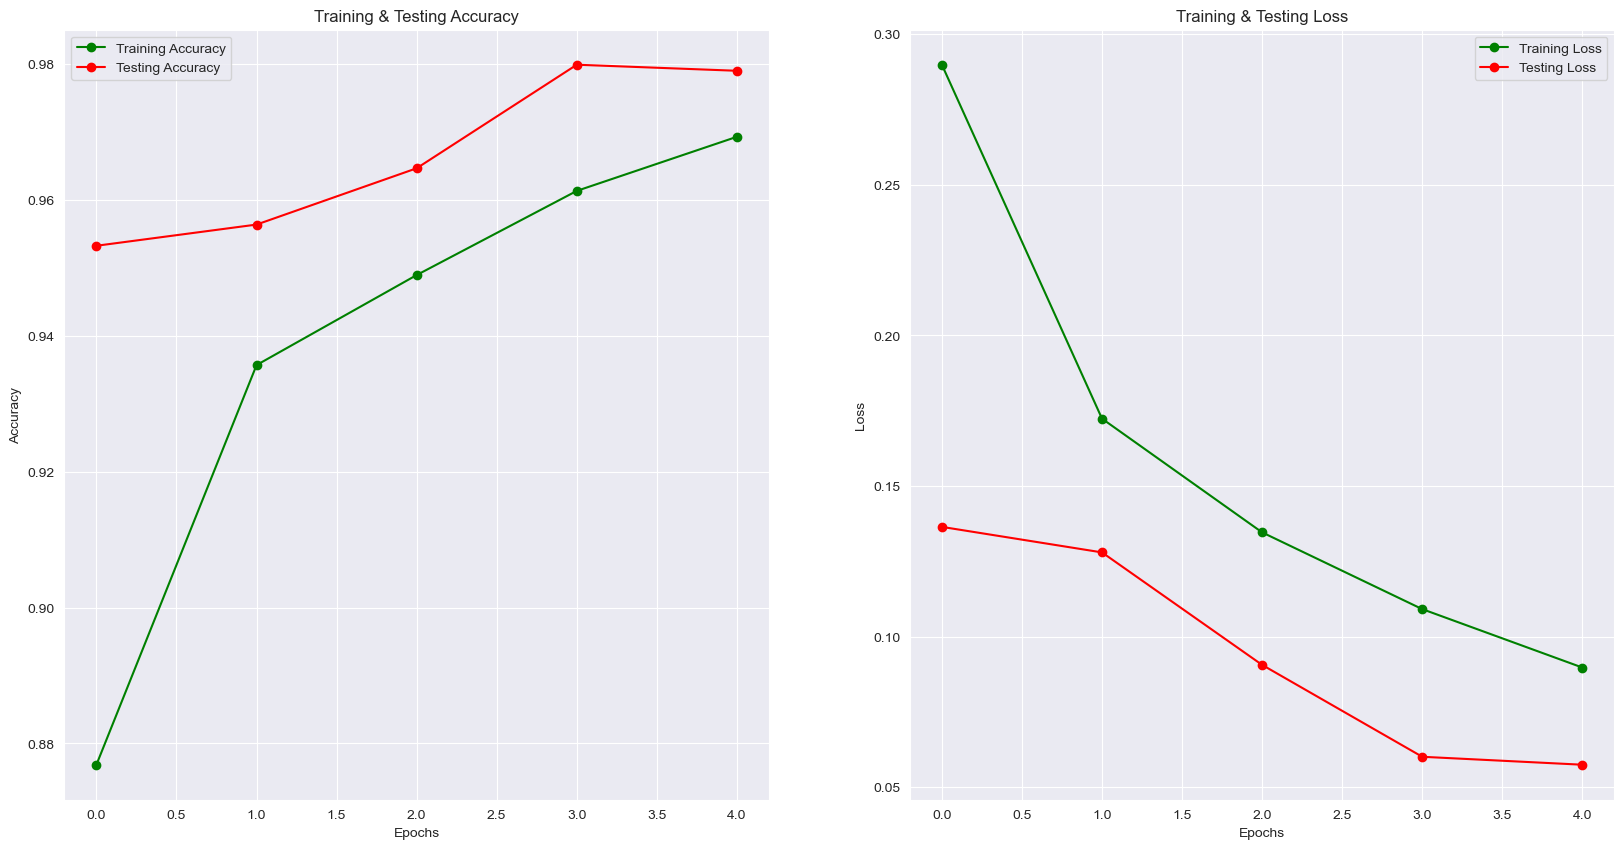

In [145]:
# Top 5 epochs

epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Model Prediction

In [146]:
len(X_test)

11225

In [147]:
pred = model.predict(X_test)

351/351 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step


In [148]:
y_pred=[]
for i in pred:
    y_pred.append(int(i[0]+0.5))

In [149]:
print(classification_report(y_test, y_pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      0.96      0.98      5858
    Not Fake       0.96      1.00      0.98      5367

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



In [150]:
# Confusion Matrix

cm = confusion_matrix(y_test,y_pred)
cm

array([[5648,  210],
       [  26, 5341]])

Text(97.72222222222221, 0.5, 'Actual')

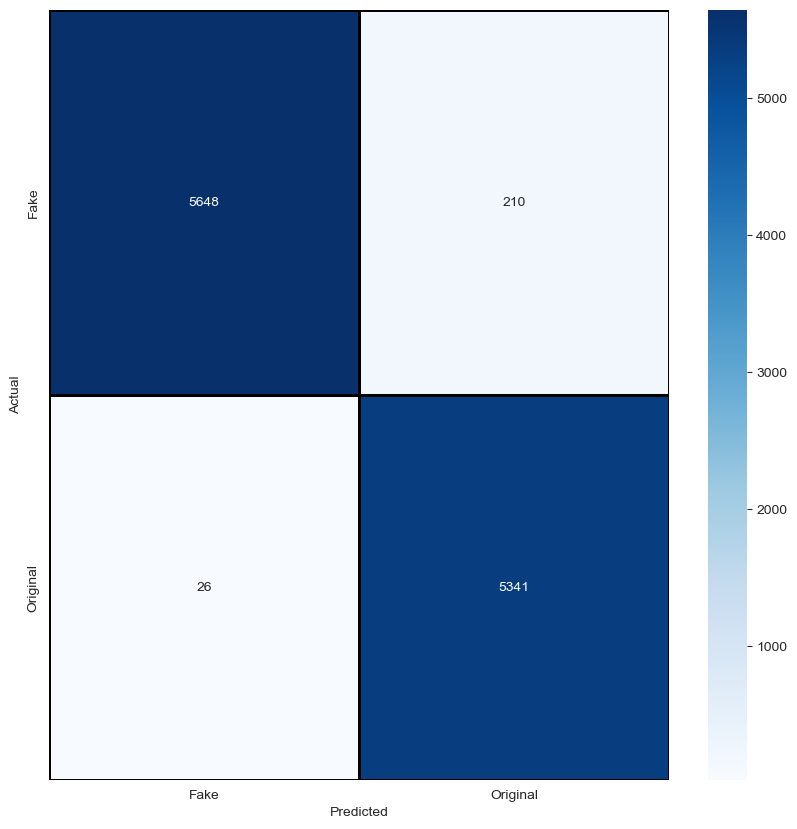

In [151]:
cm = pd.DataFrame(cm , 
                  index = ['Fake','Original'] , 
                  columns = ['Fake','Original'])

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True,
            fmt='' , 
            xticklabels = ['Fake','Original'] , 
            yticklabels = ['Fake','Original'])

plt.xlabel("Predicted")
plt.ylabel("Actual")